In [144]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import skimage.io

from skimage.measure import block_reduce
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

import eda

In [2]:
collman15v2 = np.load('../data/collman15v2_reduced.npz')
collman15v2_data = {k:v for k, v in collman15v2.iteritems()}
collman15v2_data.keys()

dict_keys(['GABA488', 'GAD647', 'gephyrin594', 'GS594', 'MBP488', 'NR1594', 'PSD95_488', 'Synapsin647', 'VGluT1_647', 'DAPI1st', 'annotation'])

In [3]:
collman14v2 = np.load('../data/collman14v2_reduced.npz')
collman14v2_data = {k:v for k, v in collman14v2.iteritems()}
collman14v2_data.keys()

dict_keys(['annotation', 'GABA', 'GAD2', 'gephyrin', 'NR1', 'PSDr', 'synapsin', 'VGluT1', 'VGAT'])

In [4]:
with open('data/centroids_collman15v2.pickle', 'rb') as f:
    collman15v2_centroids = pickle.load(f)
    
with open('data/centroids_collman14v2.pickle', 'rb') as f:
    collman14v2_centroids = pickle.load(f)

In [5]:
collman15v2_volume = []

for k, v in collman15v2_data.items():
    if k not in ['annotation', 'EM25K', 'EM10K', 'DAPI1st', 'DAPI2nd', 'DAPI3rd']:
        collman15v2_volume.append(v)
        
collman15v2_volume = np.stack(collman15v2_volume)
collman15v2_shape = collman15v2_volume.shape
collman15v2_volume.shape

(9, 27, 126, 176)

In [6]:
collman14v2_volume = []

for k, v in collman14v2_data.items():
    if k not in ['annotation']:
        collman14v2_volume.append(v)
        
collman14v2_volume = np.stack(collman14v2_volume)
collman14v2_shape = collman14v2_volume.shape
collman14v2_volume.shape

(8, 39, 361, 450)

In [7]:
collman15v2_volume = np.moveaxis(collman15v2_volume, 0, -1).reshape([-1, 9])
collman15v2_volume.shape

(598752, 9)

In [8]:
collman14v2_volume = np.moveaxis(collman14v2_volume, 0, -1).reshape([-1, 8])
collman14v2_volume.shape

(6335550, 8)

In [9]:
nmf_model = NMF(n_components=6, init='nndsvdar', solver='mu', max_iter=10000)
nmf_model.fit(collman15v2_volume)
collman15v2_nmf = nmf_model.transform(collman15v2_volume).reshape(27, 126, 176, 6)

In [10]:
nmf_model = NMF(n_components=6, init='nndsvdar', solver='mu', max_iter=10000)
nmf_model.fit(collman14v2_volume)
collman14v2_nmf = nmf_model.transform(collman14v2_volume).reshape(39, 361, 450, 6)

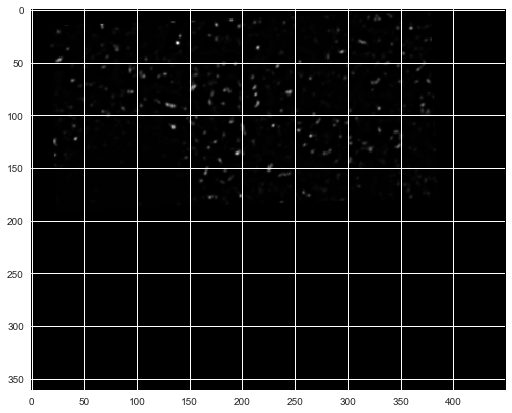

In [11]:
plt.figure(figsize=(15, 7))
plt.imshow(collman14v2_nmf[0, :, :, 0], cmap='gray')
plt.show()

In [12]:
pca_model = PCA(n_components=7)
pca_model.fit(collman15v2_volume)
collman15v2_pca = pca_model.transform(collman15v2_volume).reshape(27, 126, 176, 7)

In [14]:
pca_model = PCA(n_components=7)
pca_model.fit(collman14v2_volume)
collman14v2_pca = pca_model.transform(collman14v2_volume).reshape(39, 361, 450, 7)

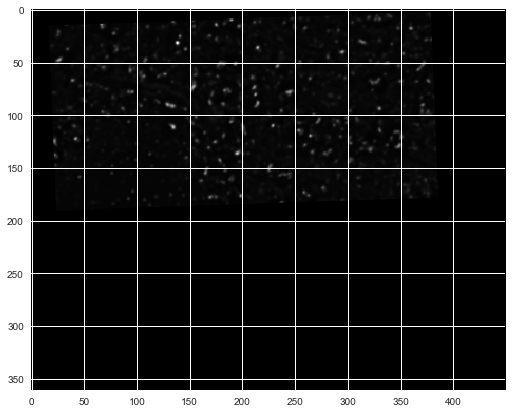

In [15]:
plt.figure(figsize=(15, 7))
plt.imshow(collman14v2_pca[0, :, :, 0], cmap='gray')
plt.show()

In [16]:
np.save('../data/collman15v2_nmf', collman15v2_nmf)
np.save('../data/collman15v2_pca', collman15v2_pca)
np.save('../data/collman14v2_nmf', collman14v2_nmf)
np.save('../data/collman14v2_pca', collman14v2_pca)

In [50]:
a = []
b = []

for i in range(collman15v2_nmf.shape[-1]):
    x, y = eda.calculate_feature(collman15v2_centroids, 
                             collman15v2_nmf[:, :, :, i], 
                             collman15v2_data['annotation'],
                             (11, 11, 11), 
                             (27, 126, 176), 
                             'f1')
    a.append(x)
    b.append(y)
    
a.append(['on_synapse'] * 236)
b.append(['around_synapse'] * 236)

In [52]:
columns = ['Component1','Component2', 'Component3', 'Component4', 'Component5', 'Component6', 'location']

collman15v2_nmf_df = pd.DataFrame(np.stack(a, axis=1), columns=columns)

temp_df = pd.DataFrame(np.stack(b, axis=1), columns = columns)

collman15v2_nmf_df = collman15v2_nmf_df.append(temp_df, ignore_index=True)

In [135]:
def do_stuff(data, annotation_channel, centroids, max_dimensions):
    a = []
    b = []
    for i in range(data.shape[-1]):
        x, y = eda.calculate_feature(centroids, 
                             data[:, :, :, i], 
                             annotation_channel,
                             (11, 11, 11), 
                             max_dimensions, 
                             'f1')
        a.append(x)
        b.append(y)
        
    a.append(['on_synapse'] * len(a[0]))
    b.append(['around_synapse'] * len(b[0]))
    
    columns = ['Component{}'.format(x+1) for x in range(data.shape[-1])]
    print(columns)
    columns.append('location')
    a_df = pd.DataFrame(np.stack(a, axis=1), columns=columns)
    b_df = pd.DataFrame(np.stack(b, axis=1), columns=columns)

    return a_df.append(b_df, ignore_index=True)

In [136]:
collman15v2_pca_f1 = do_stuff(collman15v2_pca, collman15v2_data['annotation'], collman15v2_centroids, (27, 126, 176))

['Component1', 'Component2', 'Component3', 'Component4', 'Component5', 'Component6', 'Component7']


In [137]:
collman15v2_nmf_f1 = do_stuff(collman15v2_nmf, collman15v2_data['annotation'], collman15v2_centroids, (27, 126, 176))

['Component1', 'Component2', 'Component3', 'Component4', 'Component5', 'Component6']


In [138]:
collman14v2_pca_f1 = do_stuff(collman14v2_pca, collman14v2_data['annotation'], collman14v2_centroids, (39, 361, 450))

['Component1', 'Component2', 'Component3', 'Component4', 'Component5', 'Component6', 'Component7']


In [139]:
collman14v2_nmf_f1 = do_stuff(collman14v2_nmf, collman14v2_data['annotation'], collman14v2_centroids, (39, 361, 450))

['Component1', 'Component2', 'Component3', 'Component4', 'Component5', 'Component6']


In [129]:
np.save('../data/collman15v2_nmf_f1', collman15v2_nmf_f1)
np.save('../data/collman15v2_pca_f1', collman15v2_pca_f1)
np.save('../data/collman14v2_nmf_f1', collman14v2_nmf_f1)
np.save('../data/collman14v2_pca_f1', collman14v2_pca_f1)

### Pairwise plots for PCA components

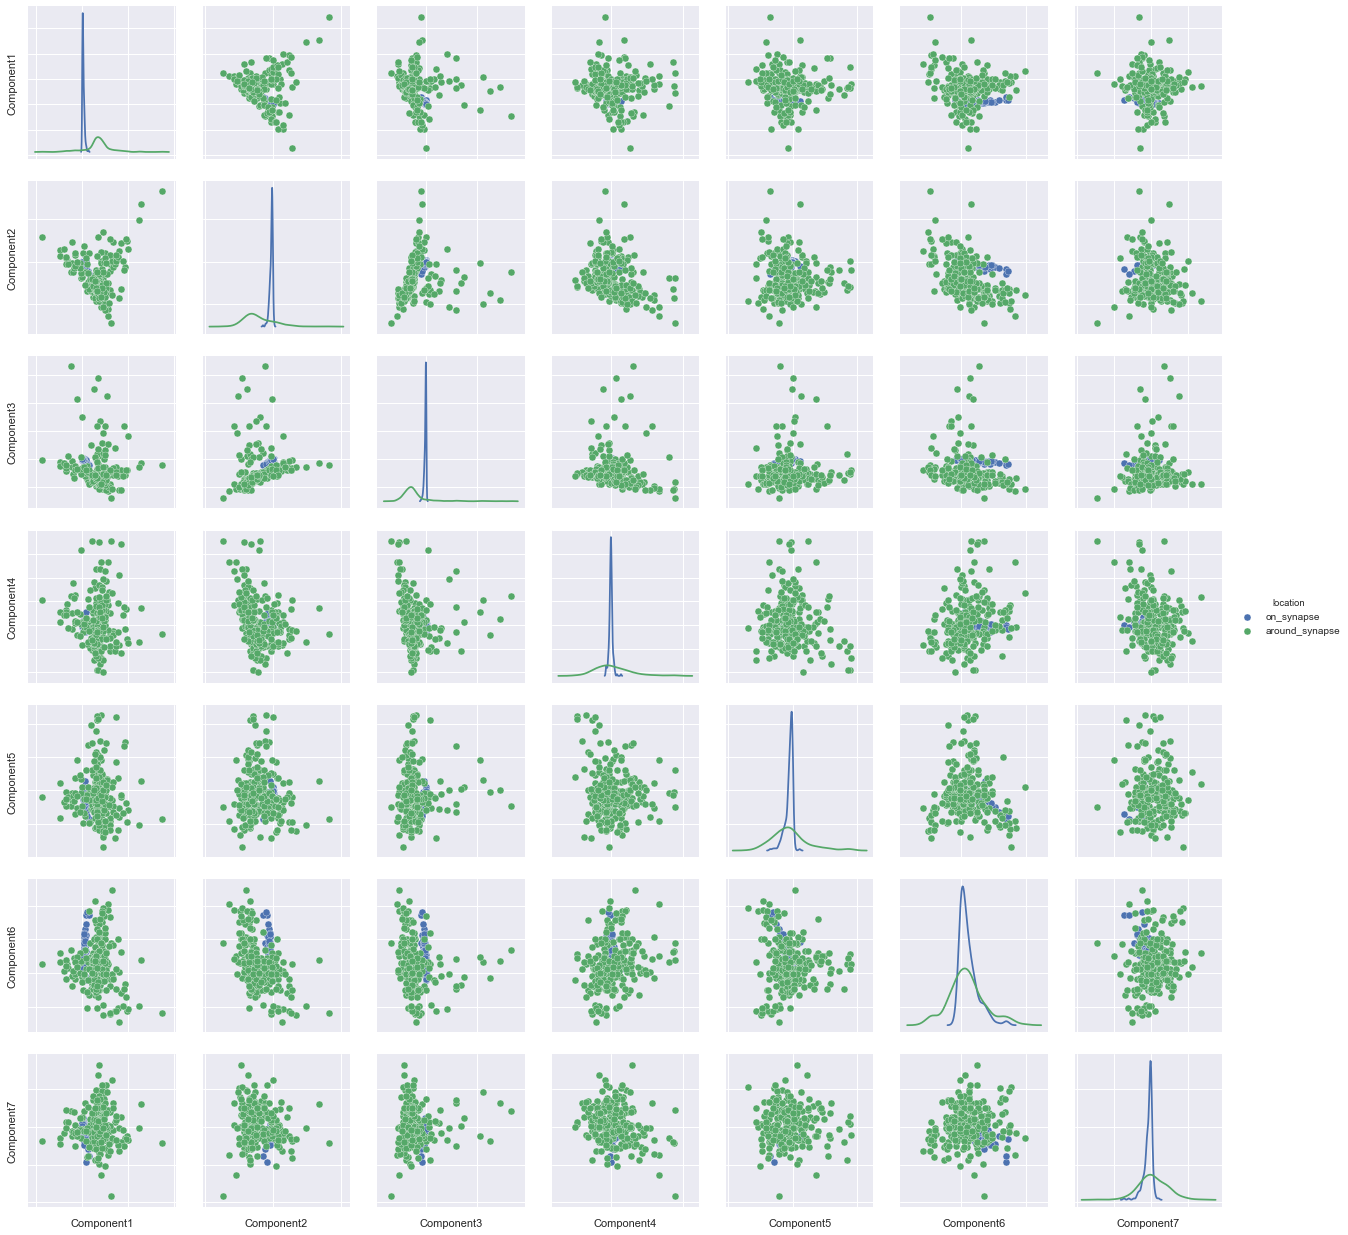

In [140]:
g = sns.pairplot(collman15v2_pca_f1, hue="location", diag_kind='kde')
g.set(xticklabels=[], yticklabels=[])
g.fig

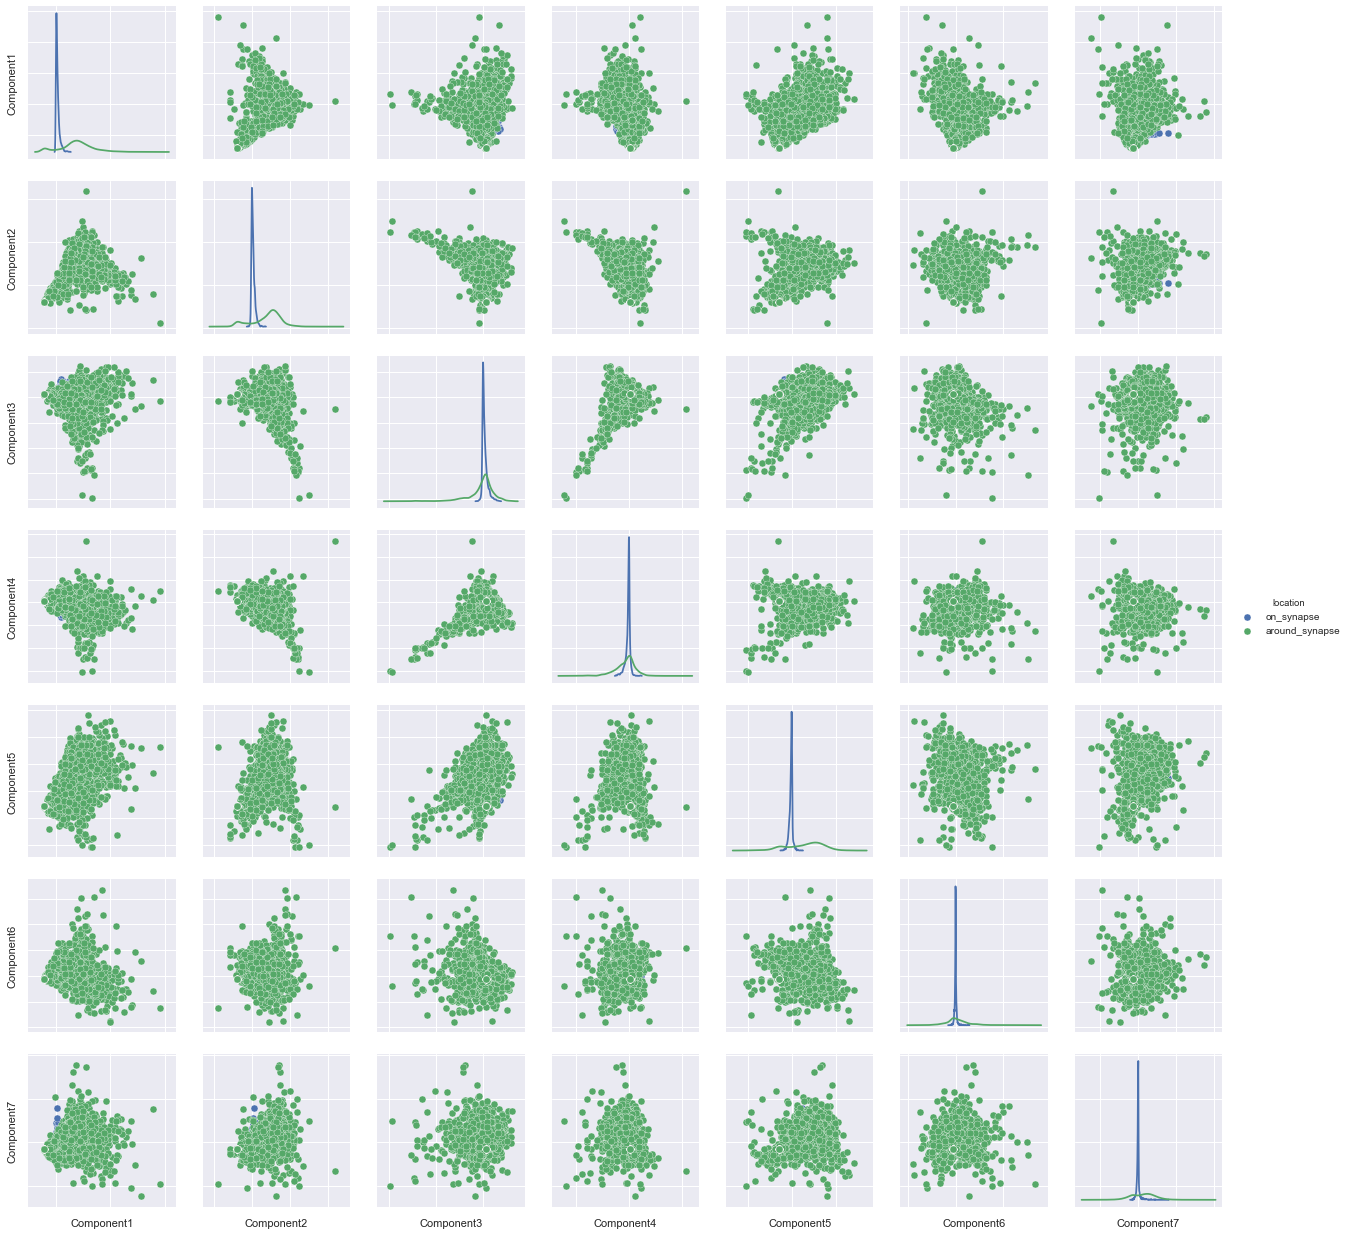

In [141]:
g = sns.pairplot(collman14v2_pca_f1, hue="location", diag_kind='kde')
g.set(xticklabels=[], yticklabels=[])
g.fig

### Pairwise plots for NMF components

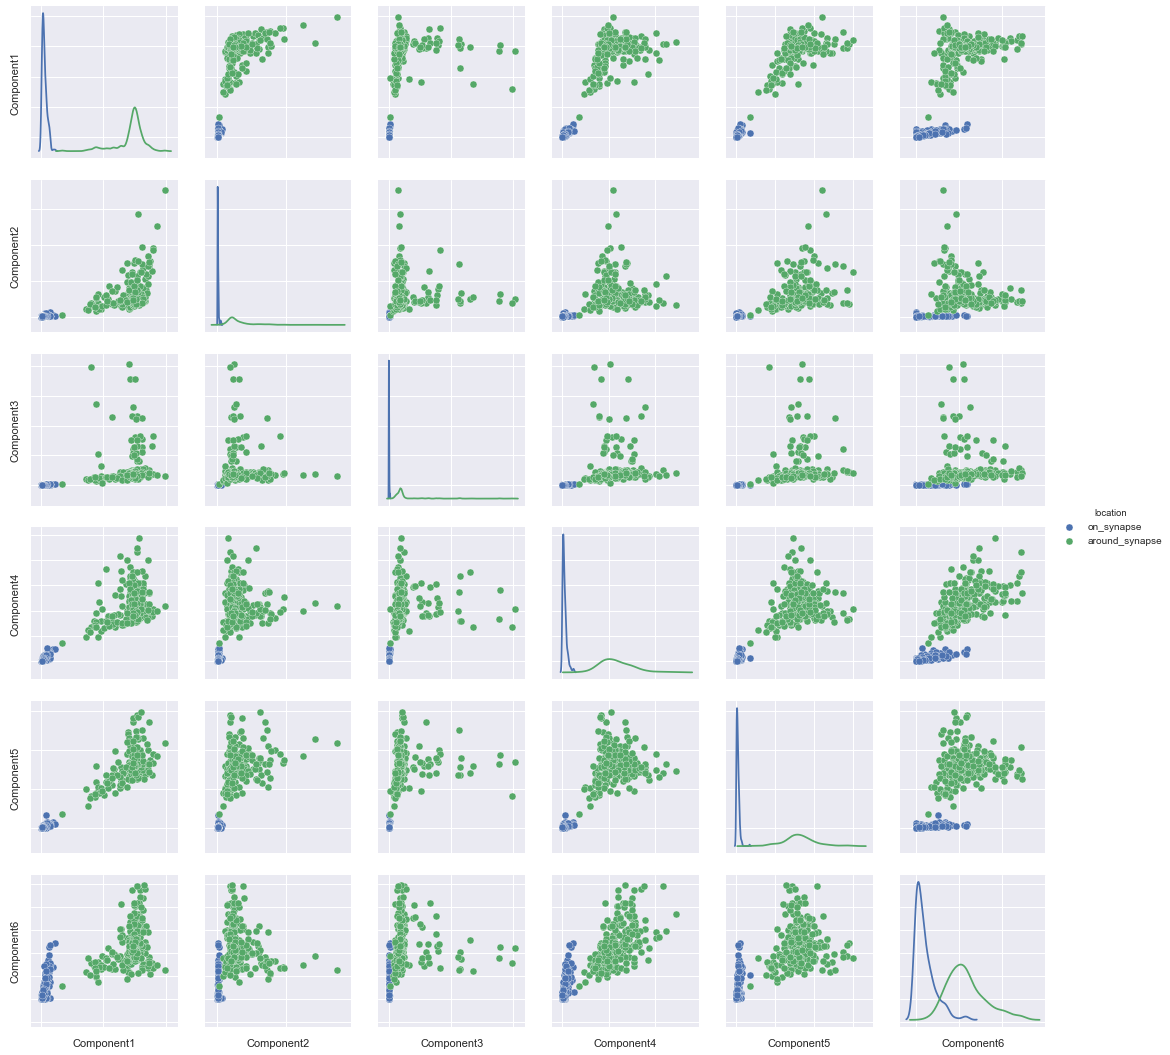

In [196]:
g = sns.pairplot(collman15v2_nmf_f1, hue="location", diag_kind='kde')
g.set(xticklabels=[], yticklabels=[])
g.fig

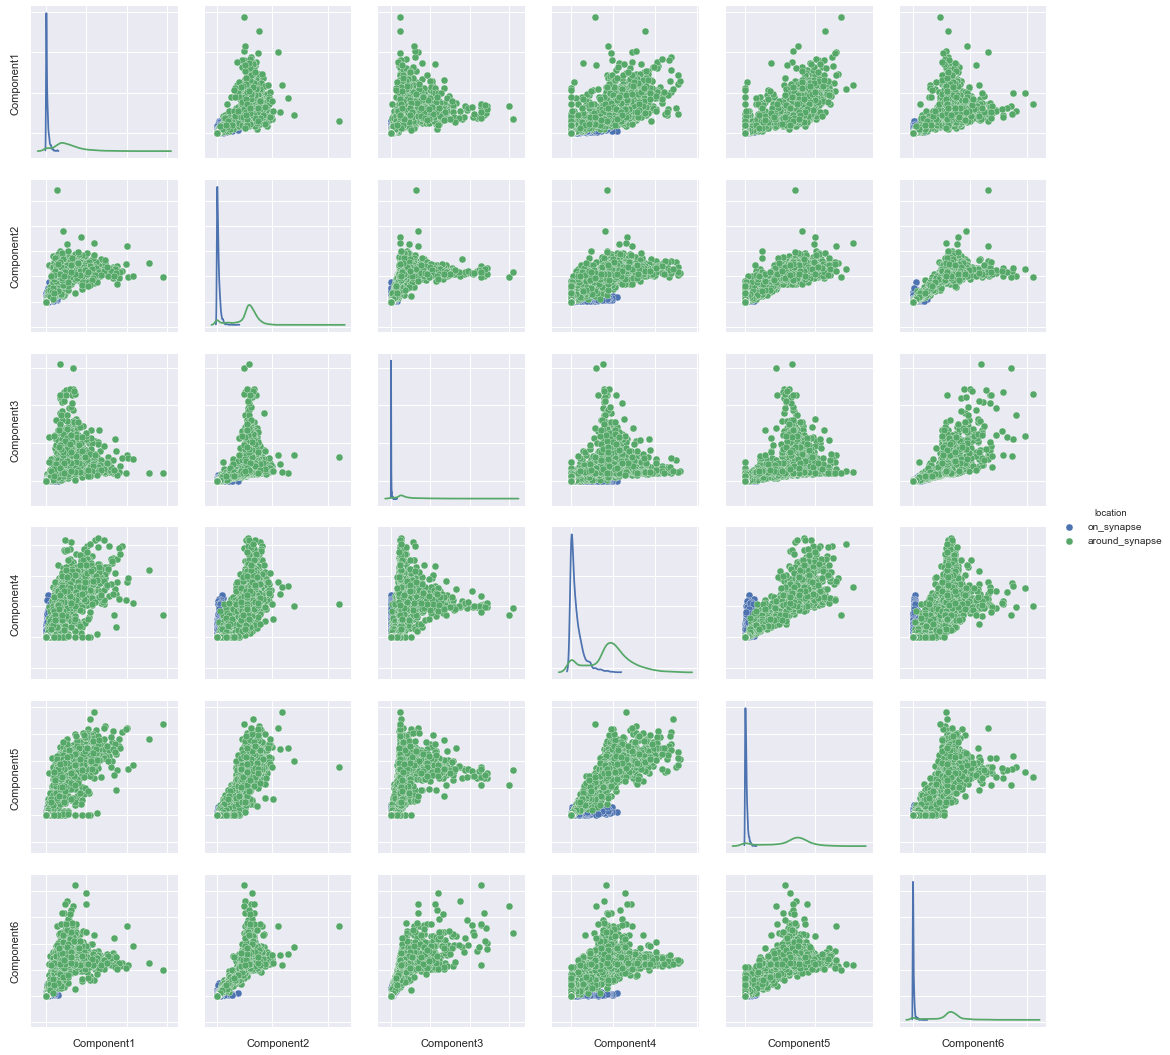

In [142]:
g = sns.pairplot(collman14v2_nmf_f1, hue="location", diag_kind='kde')
g.set(xticklabels=[], yticklabels=[])
g.fig

In [205]:
def compute_lda_qda(dataset_1, dataset_2):
    length = len(dataset_1.columns) - 1
    pairs = list(itertools.combinations(range(length), 2))

    shape = (length, length)

    #Matrix for keeping accuracy scores with shape (length, length)
    lda_in_sample_score_matrix = np.ones(shape)
    lda_out_sample_score_matrix = np.ones(shape)
    qda_in_sample_score_matrix = np.ones(shape)
    qda_out_sample_score_matrix = np.ones(shape)
    
    #Compute scores for LDA and QDA using collman14v2 as training data and collman15v2 as test data
    for i, j in pairs:
        lda_in_sample_scores = []
        lda_out_sample_scores = []
        qda_in_sample_scores = []
        qda_out_sample_scores = []

        lda = LinearDiscriminantAnalysis()
        qda = QuadraticDiscriminantAnalysis()

        X = dataset_1.iloc[:, i:j+1].values #Data
        y = dataset_1.iloc[:, -1].values #Labels

        X2 = dataset_2.iloc[:, i:j+1].values
        y2 = dataset_2.iloc[:, -1].values

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
        for test, train in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        lda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_in_sample_scores)
        lda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_out_sample_scores)

        qda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_in_sample_scores)
        qda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_out_sample_scores)
    
    for i in range(length):
        lda_in_sample_scores = []
        lda_out_sample_scores = []
        qda_in_sample_scores = []
        qda_out_sample_scores = []

        lda = LinearDiscriminantAnalysis()
        qda = QuadraticDiscriminantAnalysis()

        X = dataset_1.iloc[:, i].values.reshape(-1, 1) #Data
        y = dataset_1.iloc[:, -1].values #Labels

        X2 = dataset_2.iloc[:, i].values.reshape(-1, 1)
        y2 = dataset_2.iloc[:, -1].values

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
        for test, train in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
        for train, test in skf.split(X, y):
            lda.fit(X[train], y[train])
            qda.fit(X[train], y[train])

            lda_in_sample_scores.append(lda.score(X[test], y[test]))
            lda_out_sample_scores.append(lda.score(X2, y2))
            qda_in_sample_scores.append(qda.score(X[test], y[test]))
            qda_out_sample_scores.append(qda.score(X2, y2))

        lda_in_sample_score_matrix[(i, i)] = np.mean(lda_in_sample_scores)
        lda_out_sample_score_matrix[(i, i)] = np.mean(lda_out_sample_scores)

        qda_in_sample_score_matrix[(i, j)] = np.mean(qda_in_sample_scores)
        qda_out_sample_score_matrix[(i, j)] = np.mean(qda_out_sample_scores)
        
    return lda_in_sample_score_matrix, lda_out_sample_score_matrix, \
            qda_in_sample_score_matrix, qda_out_sample_score_matrix

In [244]:
columns_nmf = np.arange(6) + 1
columns_pca = np.arange(7) + 1

### LDA and QDA on NMF components - trained on collman15, tested on collman14

In [254]:
lda_in_sample, lda_out_sample, qda_in_sample, qda_out_sample = compute_lda_qda(collman15v2_nmf_f1, collman14v2_nmf_f1)

In [255]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample, index=columns, columns=columns)
lda_out_sample_score_df = pd.DataFrame(lda_out_sample, index=columns, columns=columns)

In [287]:
# Generate a mask for the upper triangle - for ploting later
mask = np.zeros_like(qda_out_sample, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

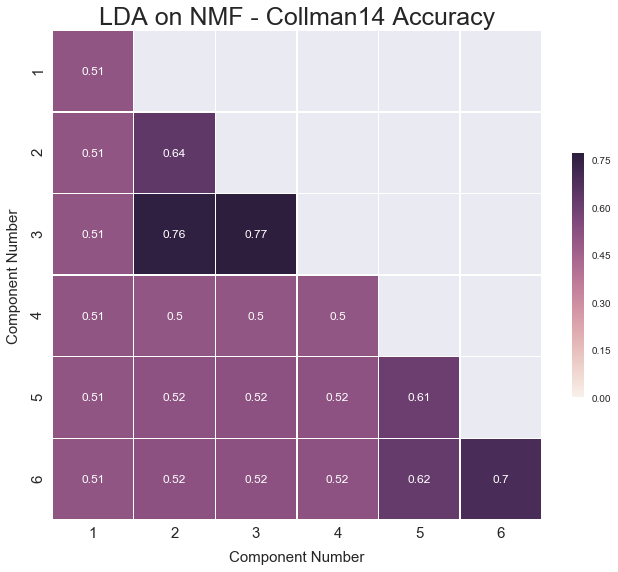

In [258]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('LDA on NMF - Collman14 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns_nmf, fontdict={'fontsize': 15})
ax.set_yticklabels(columns_nmf[::-1], fontdict={'fontsize': 15})

plt.show()

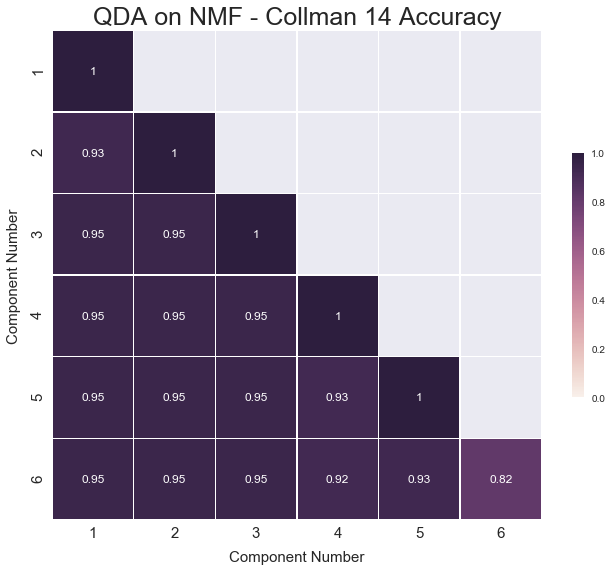

In [261]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('QDA on NMF - Collman 14 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns_nmf, fontdict={'fontsize': 15})
ax.set_yticklabels(columns_nmf[::-1], fontdict={'fontsize': 15})

plt.show()

### LDA and QDA on NMF components - trained on collman14, tested on collman15

In [284]:
lda_in_sample, lda_out_sample, qda_in_sample, qda_out_sample = compute_lda_qda(collman14v2_nmf_f1, collman15v2_nmf_f1)

In [285]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample, index=columns_nmf, columns=columns_nmf)
lda_out_sample_score_df = pd.DataFrame(lda_out_sample, index=columns_nmf, columns=columns_nmf)

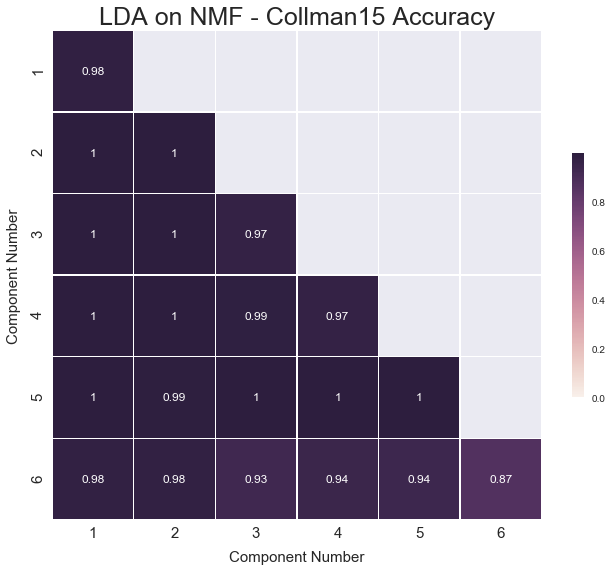

In [290]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('LDA on NMF - Collman15 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns_nmf, fontdict={'fontsize': 15})
ax.set_yticklabels(columns_nmf[::-1], fontdict={'fontsize': 15})

plt.show()

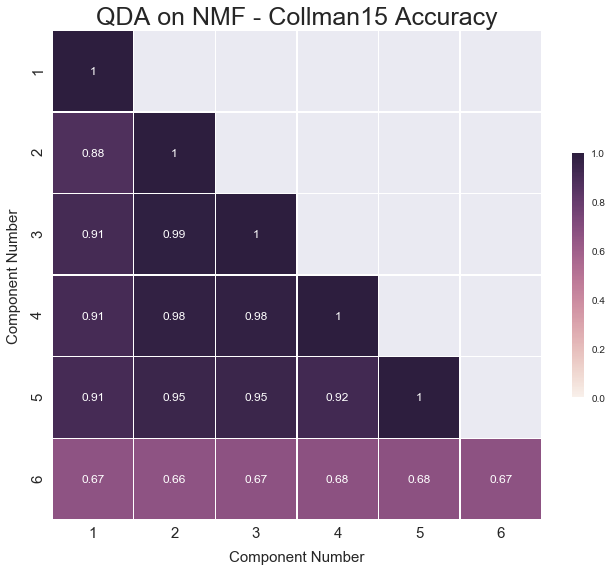

In [289]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('QDA on NMF - Collman15 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns, fontdict={'fontsize': 15})
ax.set_yticklabels(columns[::-1], fontdict={'fontsize': 15})

plt.show()

### LDA and QDA on PCA Components - trained on collman15, tested on collman14

In [280]:
lda_in_sample, lda_out_sample, qda_in_sample, qda_out_sample = compute_lda_qda(collman15v2_pca_f1, collman14v2_pca_f1)

In [267]:
# Generate a mask for the upper triangle - for ploting later
mask = np.zeros_like(qda_out_sample, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

In [281]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample)#, index=columns_nmf, columns=columns_nmf)
lda_out_sample_score_df = pd.DataFrame(lda_out_sample)#, index=columns_nmf, columns=columns_nmf)

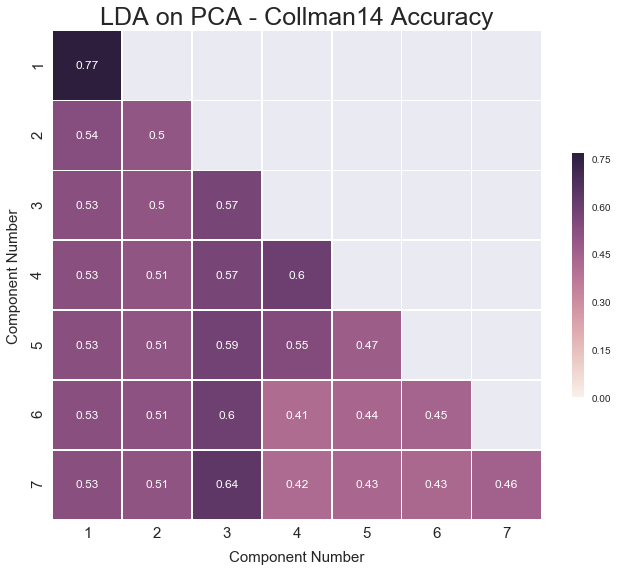

In [282]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('LDA on PCA - Collman14 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns_pca, fontdict={'fontsize': 15})
ax.set_yticklabels(columns_pca[::-1], fontdict={'fontsize': 15})

plt.show()

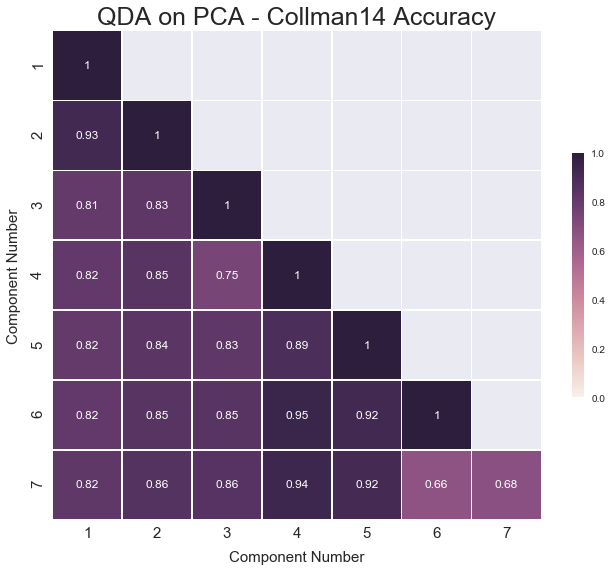

In [283]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('QDA on PCA - Collman14 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns_pca, fontdict={'fontsize': 15})
ax.set_yticklabels(columns_pca[::-1], fontdict={'fontsize': 15})

plt.show()

### LDA and QDA on PCA Components - trained on collman14, tested on collman15

In [273]:
lda_in_sample, lda_out_sample, qda_in_sample, qda_out_sample = compute_lda_qda(collman14v2_pca_f1, collman15v2_pca_f1)

In [275]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample)#, index=columns_nmf, columns=columns_nmf)
lda_out_sample_score_df = pd.DataFrame(lda_out_sample)#, index=columns_nmf, columns=columns_nmf)

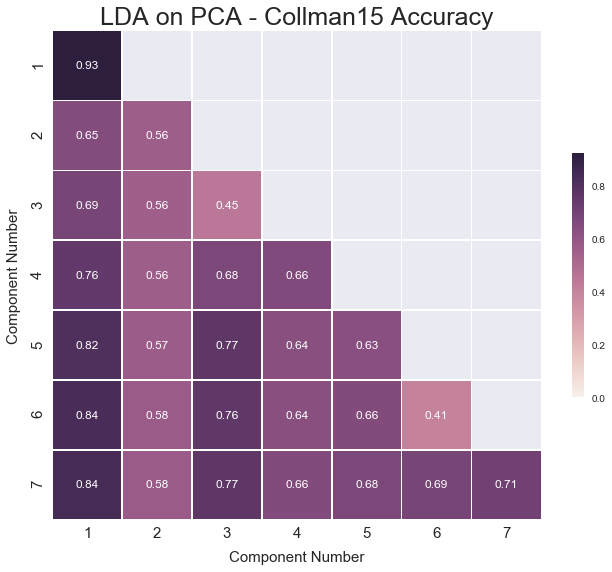

In [277]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('LDA on PCA - Collman15 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns_pca, fontdict={'fontsize': 15})
ax.set_yticklabels(columns_pca[::-1], fontdict={'fontsize': 15})

plt.show()

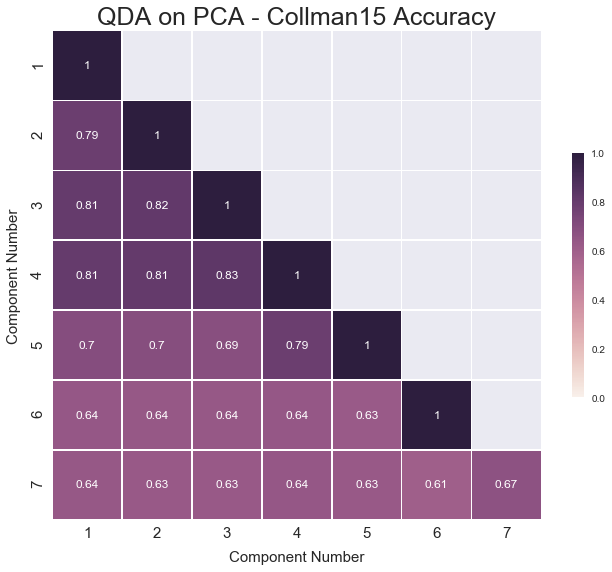

In [279]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('QDA on PCA - Collman15 Accuracy', fontdict={'fontsize': 25})
ax.set_ylabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlabel('Component Number', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xticklabels(columns_pca, fontdict={'fontsize': 15})
ax.set_yticklabels(columns_pca[::-1], fontdict={'fontsize': 15})

plt.show()